##Install dependencies and import dataset

In [2]:
!pip install langdetect
!pip3 install boto3
!pip install gensim
!pip install tqdm
!python -m spacy download fr_core_news_sm
!pip install unidecode
!pip install pyspellchecker
!pip install tensorflow-addons
!pip install wordcloud

import joblib 

from spellchecker import SpellChecker
from unidecode import unidecode
import tensorflow as tf
import tensorflow_datasets as tfds
import keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm
import re
import pathlib 
import pandas as pd 
import numpy as np
from langdetect import detect
import seaborn as sns
import io 
import matplotlib.pyplot as plt
import boto3
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

     |████████████████████████████████| 983kB 15.1MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=f08a46ffaf393ec4232ed2291d214af18146532278b3f1db3c8b21029748ed13
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 133kB 15.7MB/s 
     |████████████████████████████████| 7.3MB 20.8MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 143kB 61.3MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
/usr/local/lib/python3.7/dist-packages/requests/__init__

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:



session = boto3.Session(aws_access_key_id= YOUR_ACCESS_KEY, 
                        aws_secret_access_key= YOUR_SECRET_KEY)

s3 = session.resource("s3")
client = session.client("s3")

In [4]:
# full_dataset_reworked
obj = s3.Object('jedha-fake-reviews-project', "datasets/full_dataset.csv")
dataset = pd.read_csv(io.BytesIO(obj.get()['Body'].read()), low_memory = False, index_col=0)

dataset = dataset.reset_index(drop = True)

## Cleaning the dataset

In [5]:

######### Cleaning the dataset and adding new columns #########

#we drop rows in which restaurant infos are not available (miss scraped)
dataset = dataset.dropna(subset = ['restaurant_average_rating', 'restaurant_reviews_count', 'restaurant_expensiveness', 'restaurant_name'])
#adding a column with the length of the text review
dataset['text_length'] = dataset['text_review'].apply(lambda x : len(x))


######### Fixing existing columns values and types #########

#for the user_total_image_posted column, if user_total_image_posted is NA it means there's no image found
# so we set the value to 0
dataset.loc[dataset['user_total_image_posted'].isna(), 'user_total_image_posted'] = 0

#for the date column,  there is some miss scrapped data that we want to fix
# a correct data must have a length of 10 , if it is smaller than 10 it's because we scrapped the number of images of the user instead
# we may have to scrap again those lines to fix it
# for now, we keep only the rows where the date is correct 
mask_not_date = dataset['date'].apply(lambda x: len(x)) < 10
dataset = dataset.loc[mask_not_date == False, :]
# if te length is greater than 10 is it is beacause we scraped the date + somme additional words ('Avis mis à jour') so we will keep only the part with the date
mask_date_to_fix = dataset['date'].apply(lambda x: len(x)) > 10
dataset.loc[mask_date_to_fix, 'date' ] = dataset.loc[mask_date_to_fix, 'date' ].str.split('\n').str[0]
#finally we can convert the date column to a datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

#for the language column,
# We set all languages other than fr and eu to other to avoiding having lots of categories (causing troubles with OneHotEncoder)
mask_is_not_fr_en = (dataset['language'] != 'fr') & (dataset['language'] != 'en')
dataset.loc[mask_is_not_fr_en ,'language'] = 'other'

#for the username column,
# Setting Not Yelp User = 'Not_Yelp_User
dataset.loc[dataset['username'] == 'Not Yelp User', 'username' ] = 'Not_Yelp_User'

#for the photos_for_review column, 
# value -1 is in fact 0 (no photos found by the scraper)
dataset.loc[dataset['photos_for_review'] == '-1.0', 'photos_for_review' ] = '0'
# value L is in fact 0 (no photos found by the scraper but scraped the first letter of "L'avis du jour" which happens when the reviews was updated by the user)
dataset.loc[dataset['photos_for_review'] == 'L', 'photos_for_review' ] = '0'
# finally we can convert the photos_for_review column to an int format
dataset['photos_for_review'] = dataset['photos_for_review'].astype('int')

#for the photos_for_review column, 
# when there's no info about the expensiveness we set it to -1
dataset.loc[dataset['restaurant_expensiveness'] == 'N/C', 'restaurant_expensiveness']  = -1
# we can convert the restaurant_expensiveness column to an int format
dataset['restaurant_expensiveness'] = dataset['restaurant_expensiveness'].astype('int')

#for the is_real_review column, 
# when reverse the values 0 and 1 and rename the column is_fake_review it will make our work easier with sklearn features
dataset['is_real_review'] = dataset['is_real_review'].apply(lambda x: 1 if x == 0 else 0)
dataset.rename(columns={'is_real_review': 'is_fake_review'}, inplace=True)


dataset = dataset.reset_index(drop = True)

In [6]:
french_reviews = dataset.loc[dataset['language'] =='fr',['text_review', 'is_fake_review']]

In [7]:
# Import Spacy and french initialisation
import fr_core_news_sm
nlp = fr_core_news_sm.load()

In [8]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS

## Cleaning the text

### Remove multiple punctuation and special characters

In [9]:
def cleaner(x):
  #remove multiple punctuation
  x = re.sub(r"\.+", " . ", x)
  x = re.sub(r"\?+", " ? ", x)
  x = re.sub(r"!+", " ! ", x)
  x = re.sub(r"/", " ", x)

 #remove special char
  x = re.sub("&amp;", ' et ',x) 
  x = re.sub("&lt;", ' ',x)
  x = re.sub("&gt;", ' ',x)
  x = re.sub("\n", ' ',x)
  x = re.sub("=", ' ',x)
  x = re.sub("ª", ' ',x)
  x = re.sub("\|", ' ',x)
  x = re.sub("~", ' ',x)
  x = re.sub("{", ' ',x)
  x = re.sub("}", ' ',x)
  x = re.sub("\[", ' ',x)
  x = re.sub("\]", ' ',x)
  x = re.sub("\%", ' ',x)
  x = re.sub("\(", ' ',x)
  x = re.sub("\)", ' ',x)
  x = re.sub("\.", ' ',x)
  x = re.sub("\@.", ' ',x)
  x = re.sub("\:.", ' ',x)
  x = re.sub("©", ' ',x)
  x = re.sub("\*", ' ',x)
  x = re.sub("\=", ' ',x)
  x = re.sub(",", ' ',x)

  return x


### Expand contractions and abbreviations

In [10]:
def expand_text(x):

  #--Contractions--
  #expand negation
  x = re.sub("n'",'ne ', x) 
  #expand j'
  x = re.sub("j'",'je ', x) 
  #expand t'
  x = re.sub("t'",'te ', x) 
  #expand d'
  x = re.sub("d'",'de ', x) 
  #expand m'
  x = re.sub("m'",'me ', x)
  #expand c'
  x = re.sub("c'",'ceci ', x)  
  #expand l'
  x = re.sub("l'",'le ', x)
  #expand j'
  x = re.sub("j ",'je ', x)
  #expand n
  x = re.sub(" n ",' ne ', x)
  #expand qu'
  x = re.sub("qu'",'que ', x)

  #expand s'
  x = re.sub("s'",'se ', x)


  #--abbreviations --
  #expand €
  x = re.sub("€",' euros ', x)
  #expand $
  x = re.sub("\$",' dollars ', x)
  #expand nyc
  x = re.sub("\b(nyc)\b",' new york ', x)
  #expand m2
  x = re.sub("\b(m2)\b",' mètres carrés ', x)
  #expand m2
  x = re.sub("\b(m²)\b",' mètres carrés ', x) 
  #expand clt
  x = re.sub("\b(clt)\b",' client ', x)
  #expand QG
  x = re.sub("\b(qg)\b",' quartier général ', x)
  #expand hours, example 14h30 --> 14 heures 30
  x = re.sub("(?<=\d)[a-z]{1}", ' heures ', x)
  #expand - between numbers, example 2-3 € --> 2 à 3 euros
  x = re.sub("(?<=\d)[-]{1}(?=\d)", ' à ', x) 
  #expand / between numbers, example 2-3 € --> 2 à 3 euros
  x = re.sub("(?<=\d)[/]{1}(?=\d)", ' à ', x) 
  #expand district --> 11ème --> 11 ème arrondissement
  x = re.sub("(?<=\d)(ème)", ' ème arrondissement ', x)     


  #--fancy words--
  #whaow
  x = re.sub("\b(whaow)\w*", "waouh", x)

  #renoi
  x = re.sub("\b(renoi)\w*", "noire", x)

  #robeu
  x = re.sub("\b(robeu)\w*", "maghrébin", x)

  #rebeu
  x = re.sub("\b(rebeu)\w*", "maghrébin", x)

  #surkiff
  x = re.sub("\b(surkiff)\w*", "adore", x)

  #kiff
  x = re.sub("\b(kiff)\w*", "merveille", x)
 

  #survalide
  x = re.sub("\b(survalid)\w*", "merveille", x)

  #tuerie
  x = re.sub("tuerie", ' merveille ', x)    
  #brazil
  x = re.sub("brazil", ' brésil ', x)    
  return x

In [11]:
french_reviews["text_review_clean"] = french_reviews["text_review"].str.replace(r"[\n]", ' ').str.lower()
#expand contractions
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].apply(lambda x: expand_text(x))
#remove special character and multiple occurences of a letter
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].apply(lambda x: cleaner(x))
#remove multiple white spaces
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].str.replace(r" +"," ")
#keep only alphanum or ! or ? or -
french_reviews["text_review_clean"] = french_reviews["text_review_clean"].apply(lambda x: "".join(ch for ch in x if ch.isalnum() or ch == '!' or ch =='?' or ch ==' ' or ch == '-' or ch =='%'))

### Dealing with fancy words (words with multiple repeat of a letter)



In [12]:
#replace fancy words example "coooool" turns into --> cool
def fix_fancy_words(x):  
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(a+r+f+)\b", "décu", x)
  x = re.sub(r"\b(a+r+g+)\b", "décu", x)

  x = re.sub(r"\b(t+r+e{2,}s+)\b", "très !!", x)
  x = re.sub(r"\b(t+r+è{2,}s+)\b", "très !!", x)
  x = re.sub(r"\b(t+r+è+e{2,}s+)\b", "très !!", x)


  x = re.sub(r"\s(é+n+o{2,}r+m+e+)\w*", " énorme !!", x)
  x = re.sub(r"\b(e+n+o{2,}r+m+e+)\w*", "énorme !!", x)
  x = re.sub(r"\b(s+u{2,}p+e+r)\w*", "super !", x)

  x = re.sub(r"\b(l+o{2,}n+g+u+e+)\b", "longue !!", x)

  x = re.sub(r"\b(h+a{2,})\b", "crie !", x)
 

  x = re.sub(r"\b(t+r+o+p+)\b", "trop", x)
  x = re.sub(r"\b(b+i+e+n+)\b", "bien", x)
  x = re.sub(r"\b(b+o+n+)\b", "bon", x)
  x = re.sub(r"\b(b+o+n+e+)\b", "bonne", x)

  x = re.sub(r"\b(a+r+g+h+)\b", "décu", x)
  x = re.sub(r"\b(a+z+y+)\b", "vas y", x)
  x = re.sub(r"\b(d+o+n+f+)\b", "fond", x)
  x = re.sub(r"\b(d+o+n+f+)\b", "échec", x)
  x = re.sub(r"\b(g+o+d+)\b", "dieu", x)
  x = re.sub(r"\b(v+o+u+i+)\b", "oui", x)
  x = re.sub(r"\b(h+e+l+o+)\b", "bonjour", x)
  x = re.sub(r"\b(p+o+p+o+p+o+)\w*", "extraordinaire", x)
  x = re.sub(r"\b(p+o+u+a+f+)\b", " eh bien ! ", x)
  x = re.sub(r"\b(p+o+w+a+)\b", " vive ceci ! ", x)
  x = re.sub(r"\b(r+h+a+)\b", " que dire ", x)
  x = re.sub(r"\b(r+o+h+l+a+l+a)\b", " que dire ", x)
  x = re.sub(r"\b(r+o+l+a+l+a+l+a+)\b", " que dire ", x)
  x = re.sub(r"\b(r+o+l+a+l+a+)\b", " que dire ", x)
  x = re.sub(r"\b(s+l+u+r+p+)\b", " lécher", x)
  x = re.sub(r"\b(s+n+i+f+)\b", " dommage ", x)
  x = re.sub(r"\b(s+t+p+)\b", " s'il te plait ", x)
  x = re.sub(r"\b(s+v+p+)\b", " s'il vous plait ", x)
  x = re.sub(r"\b(l+o+l+)\b", "rires", x)
  x = re.sub(r"\b(m+d+r+)\b", "rires", x)
  x = re.sub(r"\b(t+o+p+)\b", "top", x)
  x = re.sub(r"\b(g+r+o+s+s+e)\b", "grosse", x)
  x = re.sub(r"\b(a+m+b+i+a+n+c+e+)\b", "ambiance", x)
  x = re.sub(r"\b(a+d+o+r+e+)\b", "adore", x)
 
  x = re.sub(r"\b(w+e+h+e+)\b", "ouais ouais", x)

  x = re.sub(r"\b(hy+p+e+r)\b", "hyper", x)




  x = re.sub(r"\b(w+h+o+u+h+o+u)\b", "waouh", x)
  x = re.sub(r"\b(w+h+o+w+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+h+o+w+)\b", "waouh", x)
  x = re.sub(r"\b(w+h+o+a+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+h+o+a+)\b", "waouh", x)

  #x = re.sub(r"\b(w+h+a+o+u+h+)\w+", "waouh", x)
  x = re.sub(r"\b(w+h+a+o+u+)\w*", "waouh", x) 
  x = re.sub(r"\b(w+h+a{2,})\b", "waouh", x)    
  

  x = re.sub(r"\b(w+a+o+u+h+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+o+u+a+h+)\w*", "waouh",  x) 
  #x = re.sub(r"\b(w+o+u+a+o+u+h+)\w*", "waouh", x) 
  x = re.sub(r"\b(w+o+u+h+o+u+)\w*", "waouh", x) 

  x = re.sub(r"\b(w+o+a+h)\w*", "waouh", x)
  x = re.sub(r"\b(w+o+a+w+)\w*", "waouh", x)
  x = re.sub(r"\b(w+o+u+a+)\w*", "waouh", x)

  x = re.sub(r"\b(w+o+h+o+)\w+", "waouh", x)
                        
  x = re.sub(r"\b(w+o+w+)\w+", "waouh", x)
  x = re.sub(r"\b(w+a+o+)\w+", "waouh", x)
  x = re.sub(r"\b(w+a+o+)\b", "waouh", x)
   
  x = re.sub(r"\b(w+o+h+)\w+", "waouh", x)
  x = re.sub(r"\b(w+o+h+)\b", "waouh", x)
  x = re.sub(r"\b(w+o+a+)\w*", "waouh", x)

  x = re.sub(r"\b(w+a+w+)\w+", "waouh", x)
  x = re.sub(r"\b(w+a+w+)\b", "waouh", x)

  #x = re.sub(r"\b(w+o+w+)\b", "waouh", x)
  x = re.sub(r"\b(w+o+w+)\w*", "waouh", x)


  x = re.sub(r"\b(w+a+h+)\w*", "waouh", x)
  #x = re.sub(r"\b(w+a+h+)\b", "waouh", x)

  x = re.sub(r"\b(w+a+)\b", "waouh", x)

  x = re.sub(r"\b(w+a+z+a+)\b", "waouh", x)
  x = re.sub(r"\b(y+e+a+h+)\b", "waouh", x)
  x = re.sub(r"\b(y+i+h+a+h+)\w*", "waouh", x)
  x = re.sub(r"\b(y+o+u+h+o+u+)\w*", "waouh", x)

  x = re.sub(r"\b(r+a+h+)\b", "waouh", x)

  x = re.sub(r"\b(o+u+a+h+)\b", "waouh", x)


  x = re.sub(r"\b(xi{2}e)\b", "12 ième arrondissement", x)
  x = re.sub(r"\b(xi{3}e)\b", "13 ième arrondissement", x)
  x = re.sub(r"\b(xi{3}ème)\b", "13 ième arrondissement", x)
  
  x = re.sub(r"\b(xvi{3}e)\b", "18 ième arrondissement", x)

  x = re.sub(r"\b(xième)\b", "10 ième arrondissement", x) 
  x = re.sub(r"\b(xieme)\b", "10 ième arrondissement", x)

  x = re.sub(r"\b(vième)\b", "5 ième arrondissement", x)
  x = re.sub(r"\b(vieme)\b", "5 ième arrondissement", x)

  x = re.sub(r"\b(xvième)\b", "15 ième arrondissement", x) 
  x = re.sub(r"\b(xvieme)\b", "15 ième arrondissement", x) 

  x = re.sub(r"\b(y+u+m+i+)\b", "miam", x)
  x = re.sub(r"\b(y+u+m+y+)\b", "miam", x)

  x = re.sub(r"\b(hum+)\b", "miam", x)
  x = re.sub(r"\b(hm+)\b", "miam", x)
  x = re.sub(r"\b(m+h+)\b", "miam", x)
  x = re.sub(r"\b(m){3,}\w*", "miam", x) #mmmmm --> miam or mmmmmmiam --> miam
  x = re.sub(r"\b(m+i+a+m+)\b", "miam", x)
   
  #x = re.sub(r"\b(o+h+)\w+", "plaisir", x)
  #x = re.sub(r"\b(oh+)\w+", "plaisir", x)
  #x = re.sub(r"\b(o+h)\w+", "plaisir", x)
  x = re.sub(r"\b(o+h{2,})\w+", "plaisir", x)
  x = re.sub(r"\b(o{2,}h{1})\b", "plaisir", x) #ooooooh --> plaisir
  

  x = re.sub(r"\b(p+f+)\b", "décéption", x)
  x = re.sub(r"\b(t+s{2,})\b", "décéption", x)
  x = re.sub(r"\b(o+u+i{2,})\b", "oui !!", x)

  x = re.sub(r"\b(e+u+h+)\b", "euh ?", x)

  x = re.sub(r"\b(h+u{2,}m+)\b", "hum ?", x)

  x = re.sub(r"\b(n+o{2,}n+)\b", "non !!", x)


  x = re.sub(r"\b(s+i{2,})\b", "si !!", x)

  x = re.sub(r"\b(me+i+l{3,}e+u+r+)\w*", "meilleur !!", x)
  x = re.sub(r"\b(t+e+l+e+m+e+n+t+)\b", "tellement ", x)
  x = re.sub(r"\b(b+e+a+u+c+o+u+p+)\b", "beaucoup", x)

  x = re.sub(r"\b(a+l{3,}e+r+)\b", "aller !! ", x)
  x = re.sub(r"\b(a+l{3,}e+z+)\b", "allez !! ", x)

  x = re.sub(r"\b(o+u{3,}h+)\b", "ouh !! ", x)
  x = re.sub(r"\b(n+o+u+r{3,}i+t+u+r+e+)\w*", "nourriture !! ", x)
  x = re.sub(r"\b(t+e+r{3,}i+b+l+e+)\w*", "terrible ! ", x)
  x = re.sub(r"\b(g+r+a{2,}v+e+)\w*", "grave ! ", x)
  x = re.sub(r"\b(b+o+f+)\b", "moyen", x)

  x = re.sub(r"\b(ah+)\w+", "bonheur", x)
  x = re.sub(r"\b(a+){2}\w+", "bonheur", x) #aaaaaaaa --> bonheur
  x = re.sub(r"\b(gr{2,})\b", "grognement", x) #grrrrr -> grognement
  x = re.sub(r"\b(br{2,})\b", "froid", x) #brrrrr -> froid
  x = re.sub(r"\b(b+e+u+r+k+)\b", "beurk", x)

  x = re.sub(r"\b(w+h+a+t+)\b", "quoi ", x)

  x = re.sub(r"\b(s+o{3,})\b", "vraiment ! ", x)


  x = re.sub(r"\b(p+f+i+o+u+)\b", "soulagement ! ", x)
  x = re.sub(r"\b(o+u+f+)\b", "soulagement ", x)
  x = re.sub(r"\b(c+h+u+t+)\b", "silence ", x)

  x = re.sub(r"\b(b+i+m+)\b", "boom", x)

  x = re.sub(r"\b(ver{3,}e)\b", "verre", x)
   

  return x

In [13]:
french_reviews['text_review_clean'] = french_reviews['text_review_clean'].apply(lambda x: fix_fancy_words(x))

In [14]:
#french_reviews['text_lemma'] = french_reviews['text_review_clean'].apply(lambda x : " ".join(token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS))

In [15]:
french_reviews['text_review_clean'].head()

0    bon retour ! je suis revenue dans ce resto apr...
1    a optimiser cuisine très traditionnelle dans u...
2    brasserie chic une brasserie authentiquement p...
3    tres bien petit diner entre amis les plats eta...
4    un bistrot bien sympathique nous avons mangé e...
Name: text_review_clean, dtype: object

Now there are still some other fancy words, to get the exhaustive list we decide to explicitely search for them in our corpus thanks to a regex function

In [16]:
#we define a function that will match words with more than 2 letters repeated like "cooool", "tooooooop"
pattern = re.compile(r"\w+([a-z])\1{2}\w+")
def get_fancy_word(text):
  fancylist = [m.group(0) for m in pattern.finditer(text)]
  return fancylist


In [17]:
#get a list for each rows
fancy_words = french_reviews['text_review_clean'].apply(lambda x: get_fancy_word(x))
#get a flatlist from all the lists
fancy_words = [word for sublist in fancy_words for word in sublist]
#get a df
fancy_df = pd.DataFrame({'fancy_words': fancy_words})

In [18]:
fancy_df.value_counts()[0:20]

fancy_words  
triiiiiste       2
bouuuh           2
terrrasse        2
unagiiii         2
baaah            2
uuuuultra        2
ellle            2
mojitoooo        2
hmmmoke          2
loooooong        2
corrrect         2
atttendre        2
haaaaan          2
raisonnnable     2
etttttt          2
looooove         2
classsique       2
pizzaaaaaa       2
lonnnnngtemps    2
graaaaande       2
dtype: int64

In [19]:
#get unique fancy words
fancy_words_unique = np.unique(fancy_words)
#remove multiple repeat of a letter
repeat_pattern = re.compile(r'(\w)\1*')
substitution = r'\1'
fancy_words_fixed = [repeat_pattern.sub(substitution, word) for word in fancy_words_unique]
#We have to retake unique values as for example 'suuuuper' and suppppper' are now both 'super' so there are duplicates
fancy_words_fixed = np.unique(fancy_words_fixed)

In [20]:
fancy_words_fixed[0:20]

array(['absolument', 'aceuil', 'aceuile', 'acompagné', 'acompagnés',
       'acord', 'acueil', 'acueilant', 'adorable', 'adorent', 'adores',
       'adoreu', 'adoré', 'adrese', 'aie', 'ailes', 'aileurs', 'aime',
       'aimée', 'alez'], dtype='<U17')

now we have to create a dictionnary in which keys are fancy words and values are these actual words written correctly, we won't do this manually, let's use a spell checker to do this.

In [21]:
spell = SpellChecker(language='fr')
fw_dict = {}
for word in fancy_words_fixed:
  fw_dict[word]= spell.correction(word)


Now, when double checking we realized that there are some bugs in the correction, we will fix them manually

In [22]:
fw_dict['aceuile'] = 'aceuille'
fw_dict['alor'] = 'alors'
fw_dict['anciene'] = 'ancienne'
fw_dict['argentina'] = 'argentina'
fw_dict['areba'] = 'areeba'
fw_dict['ausi'] = 'aussi'
fw_dict['baise'] = 'baisse'
fw_dict['beaucoupde'] = 'beaucoup de'
fw_dict['boison'] = 'boisson'
fw_dict['bone'] = 'bonne'
fw_dict['boyah'] = 'boyah'
fw_dict['brasens'] = 'brassens'
fw_dict['buz'] = 'buzz'
fw_dict['bôo'] = 'bôo'
fw_dict['carotes'] = 'carottes'
fw_dict['charal'] = 'charal'
fw_dict['chatilon'] = 'chatillon'
fw_dict['cheminéehum'] = 'cheminée hum'
fw_dict['chery'] = 'cherry'
fw_dict['chaufe'] = 'chauffe'
fw_dict['chery'] = 'cherry'
fw_dict['chese'] = 'cheese'
fw_dict['come'] = 'comme'
fw_dict['conseile'] = 'conseille'
fw_dict['cuisons'] = 'cuissons'
fw_dict['desertsmh'] = 'desserts mh'
fw_dict['dona'] = 'donna'
fw_dict['ele'] = 'elle'
fw_dict['haloumi'] = 'halloumi'
fw_dict['gentilese'] = 'gentillesse'
fw_dict['hohey'] = 'ho hey'
fw_dict['imonde'] = 'immonde'
fw_dict['iranienes'] = 'iraniennes'
fw_dict['jinete'] = 'ginette'
fw_dict['kawai'] = 'kawaï'
fw_dict['kawaï'] = 'kawaï'
fw_dict['keurs'] = 'coeur'
fw_dict['kewa'] = 'quoi'
fw_dict['kro'] = 'kro'
fw_dict['laise'] = "l'aise"
fw_dict['laise'] = "l'aise"
fw_dict['mare'] = "marre"
fw_dict['làa'] = "là"
fw_dict['meow'] = "meow"
fw_dict['meusieu'] = "monsieur"
fw_dict['meow'] = "meow"
fw_dict['mezeh'] = "mezeh"
fw_dict['mouahahahahahumpf'] = "rires"
fw_dict['moultes'] = "moultes"
fw_dict['nikos'] = "nikos"
fw_dict['nonmais'] = "non mais"
fw_dict['nouriture'] = "nourriture"
fw_dict['obstines'] = "obstinés"
fw_dict['oishi'] = "oishi"
fw_dict['ouai'] = "ouais"
fw_dict['pasé'] = "passé"
fw_dict['pfiu'] = "pfiou"
fw_dict['pfou'] = "pfiou"
fw_dict['pfu'] = "pfiou"
fw_dict['pikant'] = "piquant"
fw_dict['pouaf'] = "pouaf"
fw_dict['pouri'] = "pourri"
fw_dict['pouser'] = "pousser"
fw_dict['pousives'] = "poussives"
fw_dict['psch'] = "psch"
fw_dict['raport'] = "rapport"
fw_dict['rehm'] = "rehm"
fw_dict['reverais'] = "reverais"
fw_dict['rh'] = "rh"
fw_dict['rha'] = "rh"
fw_dict['riletes'] = "rillettes"
fw_dict['rilete'] = "rillette"
fw_dict['récement'] = "récemment"
fw_dict['réelement'] = "réellement"
fw_dict['rilete'] = "rillette"
fw_dict['saléstrèsalé'] = "salés très salés"
fw_dict['sexis'] = "sexy"
fw_dict['sétend'] = "s'étend"
fw_dict['somes'] = 'sommes'
fw_dict['tading'] = 'tading'
fw_dict['sugoi'] = 'sugoi'
fw_dict['taile'] = 'taille'
fw_dict['tase'] = 'tasse'
fw_dict['terase'] = 'terrasse'
fw_dict['trufes'] = 'truffes'
fw_dict['turene'] = 'turenne'
fw_dict['unagi'] = 'unagi'
fw_dict['xl'] = 'énorme'

In [23]:
#re_pattern_list = [ r"\b"+"(" + "".join(ch + '+' for ch in word) + ")"+r"\b" +'|' for word in fw_dict.keys() if len(word) >3]
#re_pattern = "".join(p for p in re_pattern_list)
#pattern = re.compile(re_pattern)
#Now let's correct all the words in this dictionnary 



In [132]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
  display(french_reviews.sample(100).loc[:, ['text_review', 'text_review_clean']])


,text_review,text_review_clean
57022,"Agréable surprise\nJ'ai découvert ce restaurant par le guide Michelin, et j'ai vraiment beaucoup apprécié le cadre intimiste, l'accueil est souriant. La cuisine est délicieuse, beaucoup de plats qu'on ne retrouvent pas ailleurs et de qualité qui valent leur prix. Très bonne adresse à Paris.",agréable surprise je ai découvert ce restaurant par le guide michelin et je ai vraiment beaucoup apprécié le cadre intimiste le accueil est souriant la cuisine est délicieuse beaucoup de plats que on ne retrouvent pas ailleurs et de qualité qui valent leur prix très bonne adresse à paris
92326,"Le meilleur tartare de Paris.\nExcellentes tartes maison.\nPetites charcuterie coupée minute au comptoirs.\nSuivez les conseils du patron pour les vins, il ne se trompe jamais!\n\nAu top.",le meilleur tartare de paris excellentes tartes maison petites charcuterie coupée minute au comptoirs suivez les conseils du patron pour les vins il ne se trompe jamais ! au top
43200,Excellente adresse\nProduits toujours très frais\nCertaines spécialités délicieuses\nEt l'accueil de Sylvie est impeccable,excellente adresse produits toujours très frais certaines spécialités délicieuses et le accueil de sylvie est impeccable
15566,Une valeur sûre en terme de qualité et des tarifs corrects !,une valeur sûre en terme de qualité et des tarifs corrects !
54015,"Encore un pub minable près des Champs. Il fut un temps où c'était un pub anglais très convenable. Aujourd'hui ça n'attire plus qu'une clientèle de gros lourdingues qui ne semble pas être au courant qu'il y a plein d'endroits sympas à Paris en dehors des Champs Elysées!!! maintenant, si vous aimez les serveurs indifférents, le bruit, les gens qui parlent fort et vous tombent dessus car déjà bourrés en arrivant au pub et la bière coupée à l'eau, grand bien vous fasse!",encore un pub minable près des champs il fut un temps où ceci était un pub anglais très convenable aujourde hui ça ne attire plus que une clientèle de gros lourdingues qui ne semble pas être au courant que il y a plein de endroits sympas à paris en dehors des champs elysées ! maintenant si vous aimez les serveurs indifférents le bruit les gens qui parlent fort et vous tombent dessus car déjà bourrés en arrivant au pub et la bière coupée à le eau grand bien vous fasse !
17803,"Une superbe soirée passée entre amis.\nEn entrée, nous avons partagé un assortiment de rissol et un choriço qui a été flambé devant nos yeux.\nNous nous sommes laissés tenter par le quart se poulet avec frites (largement suffisant pour mon ventre de femme enceinte), mention spéciale pour la sauce Nossa, et nos compagnons ont testé le plat du jour qui était à base de morue.\nPour terminer ce chouette moment, les traditionnels pasteis nous ont ramenés vers nos souvenirs de vacances passés il y a quelques années à Lisbonnes.\nLe serveur était vraiment sympa et attentionné. La décoration est vraiment cool également, bref tout est réuni pour passer un bon moment.",une superbe soirée passée entre amis en entrée nous avons partagé un assortiment de rissol et un choriço qui a été flambé devant nos yeux nous nous sommes laissés tenter par le quart se poulet avec frites largement suffisant pour mon ventre de femme enceinte mention spéciale pour la sauce nossa et nos compagnons ont testé le plat du jour qui était à base de morue pour terminer ce chouette moment les traditionnels pasteis nous ont ramenés vers nos souvenirs de vacances passés il y a quelques années à lisbonnes le serveur était vraiment sympa et attentionné la décoration est vraiment cool également bref tout est réuni pour passer un bon moment
5108,Décor comme à Tokyo bon goût et dépaysement jusqu au tabouret . Les ramen sont excellents et le personnel très aimable,décor comme à tokyo bon goût et dépaysement jusqu au tabouret les ramen sont excellents et le personnel très aimable
40037,"Quatre étoiles pour cette adresse qui n'a pas besoin de ma critique pour parfaire sa réputation. Un sp

In [25]:
french_reviews['is_fake_review'].value_counts()

0    73211
1    17386
Name: is_fake_review, dtype: int64

## Wordclouds

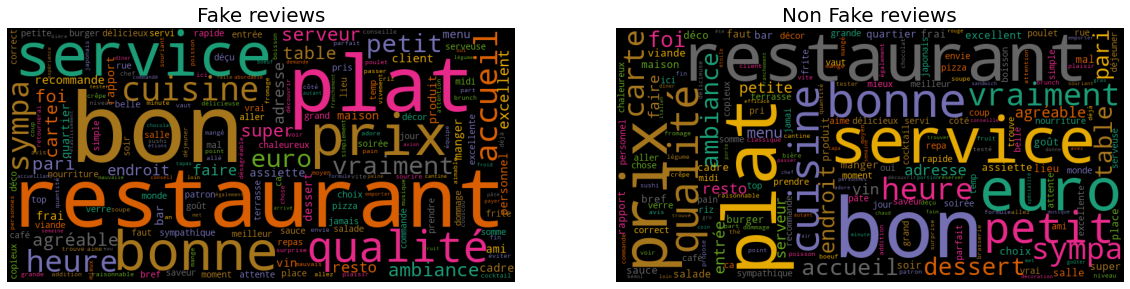

In [27]:
not_disaster = ' '.join(french_reviews[french_reviews['is_fake_review'] == 0]['text_review_clean'].str.replace(r" +", " "))
disaster = ' '.join(french_reviews[french_reviews['is_fake_review'] == 1]['text_review_clean'].str.replace(r" +", " "))

wordcloud_disaster = WordCloud(max_font_size=None, stopwords= STOP_WORDS,scale = 2,colormap = 'Dark2',collocations = False).generate(disaster)
wordcloud_not_disaster = WordCloud(max_font_size=None, stopwords= STOP_WORDS, scale = 2,colormap = 'Dark2',collocations = False).generate(not_disaster)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_disaster)
ax[0].set_title('Fake reviews',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_not_disaster)
ax[1].set_title('Non Fake reviews',fontsize = 20)
ax[1].axis("off")

plt.show()

## Ngram Analysis

In [28]:
#Function to generate ngrams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split() if token != '' if token not in STOP_WORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [29]:
#function to generate ngram dataframes for non fake and fake
from collections import defaultdict
def make_ngram_df(df, n_gram = 1, labels=[0,1]):
  df_list = []
  for i in labels:
    Dict = defaultdict(int)
    for review in df.loc[df['is_fake_review'] == i,'text_review_clean']:
      for word in generate_ngrams(review, n_gram = n_gram):
        Dict[word] += 1
    df_n_gram = pd.DataFrame(sorted(Dict.items(), key=lambda x: x[1])[::-1])
    df_list.append(df_n_gram)
  
  return df_list[0], df_list[1] #0 = non fake, 1 = fake


In [30]:
df = french_reviews

non_fake_df_unigram, fake_df_unigram = make_ngram_df(df, n_gram = 1) #unigram
non_fake_df_bigram, fake_df_bigram = make_ngram_df(df, n_gram = 2) # bigram
non_fake_df_trigram, fake_df_trigram = make_ngram_df(df, n_gram = 3) # trigram
non_fake_df_fourgram, fake_df_fourgram = make_ngram_df(df, n_gram = 4) # fourgram

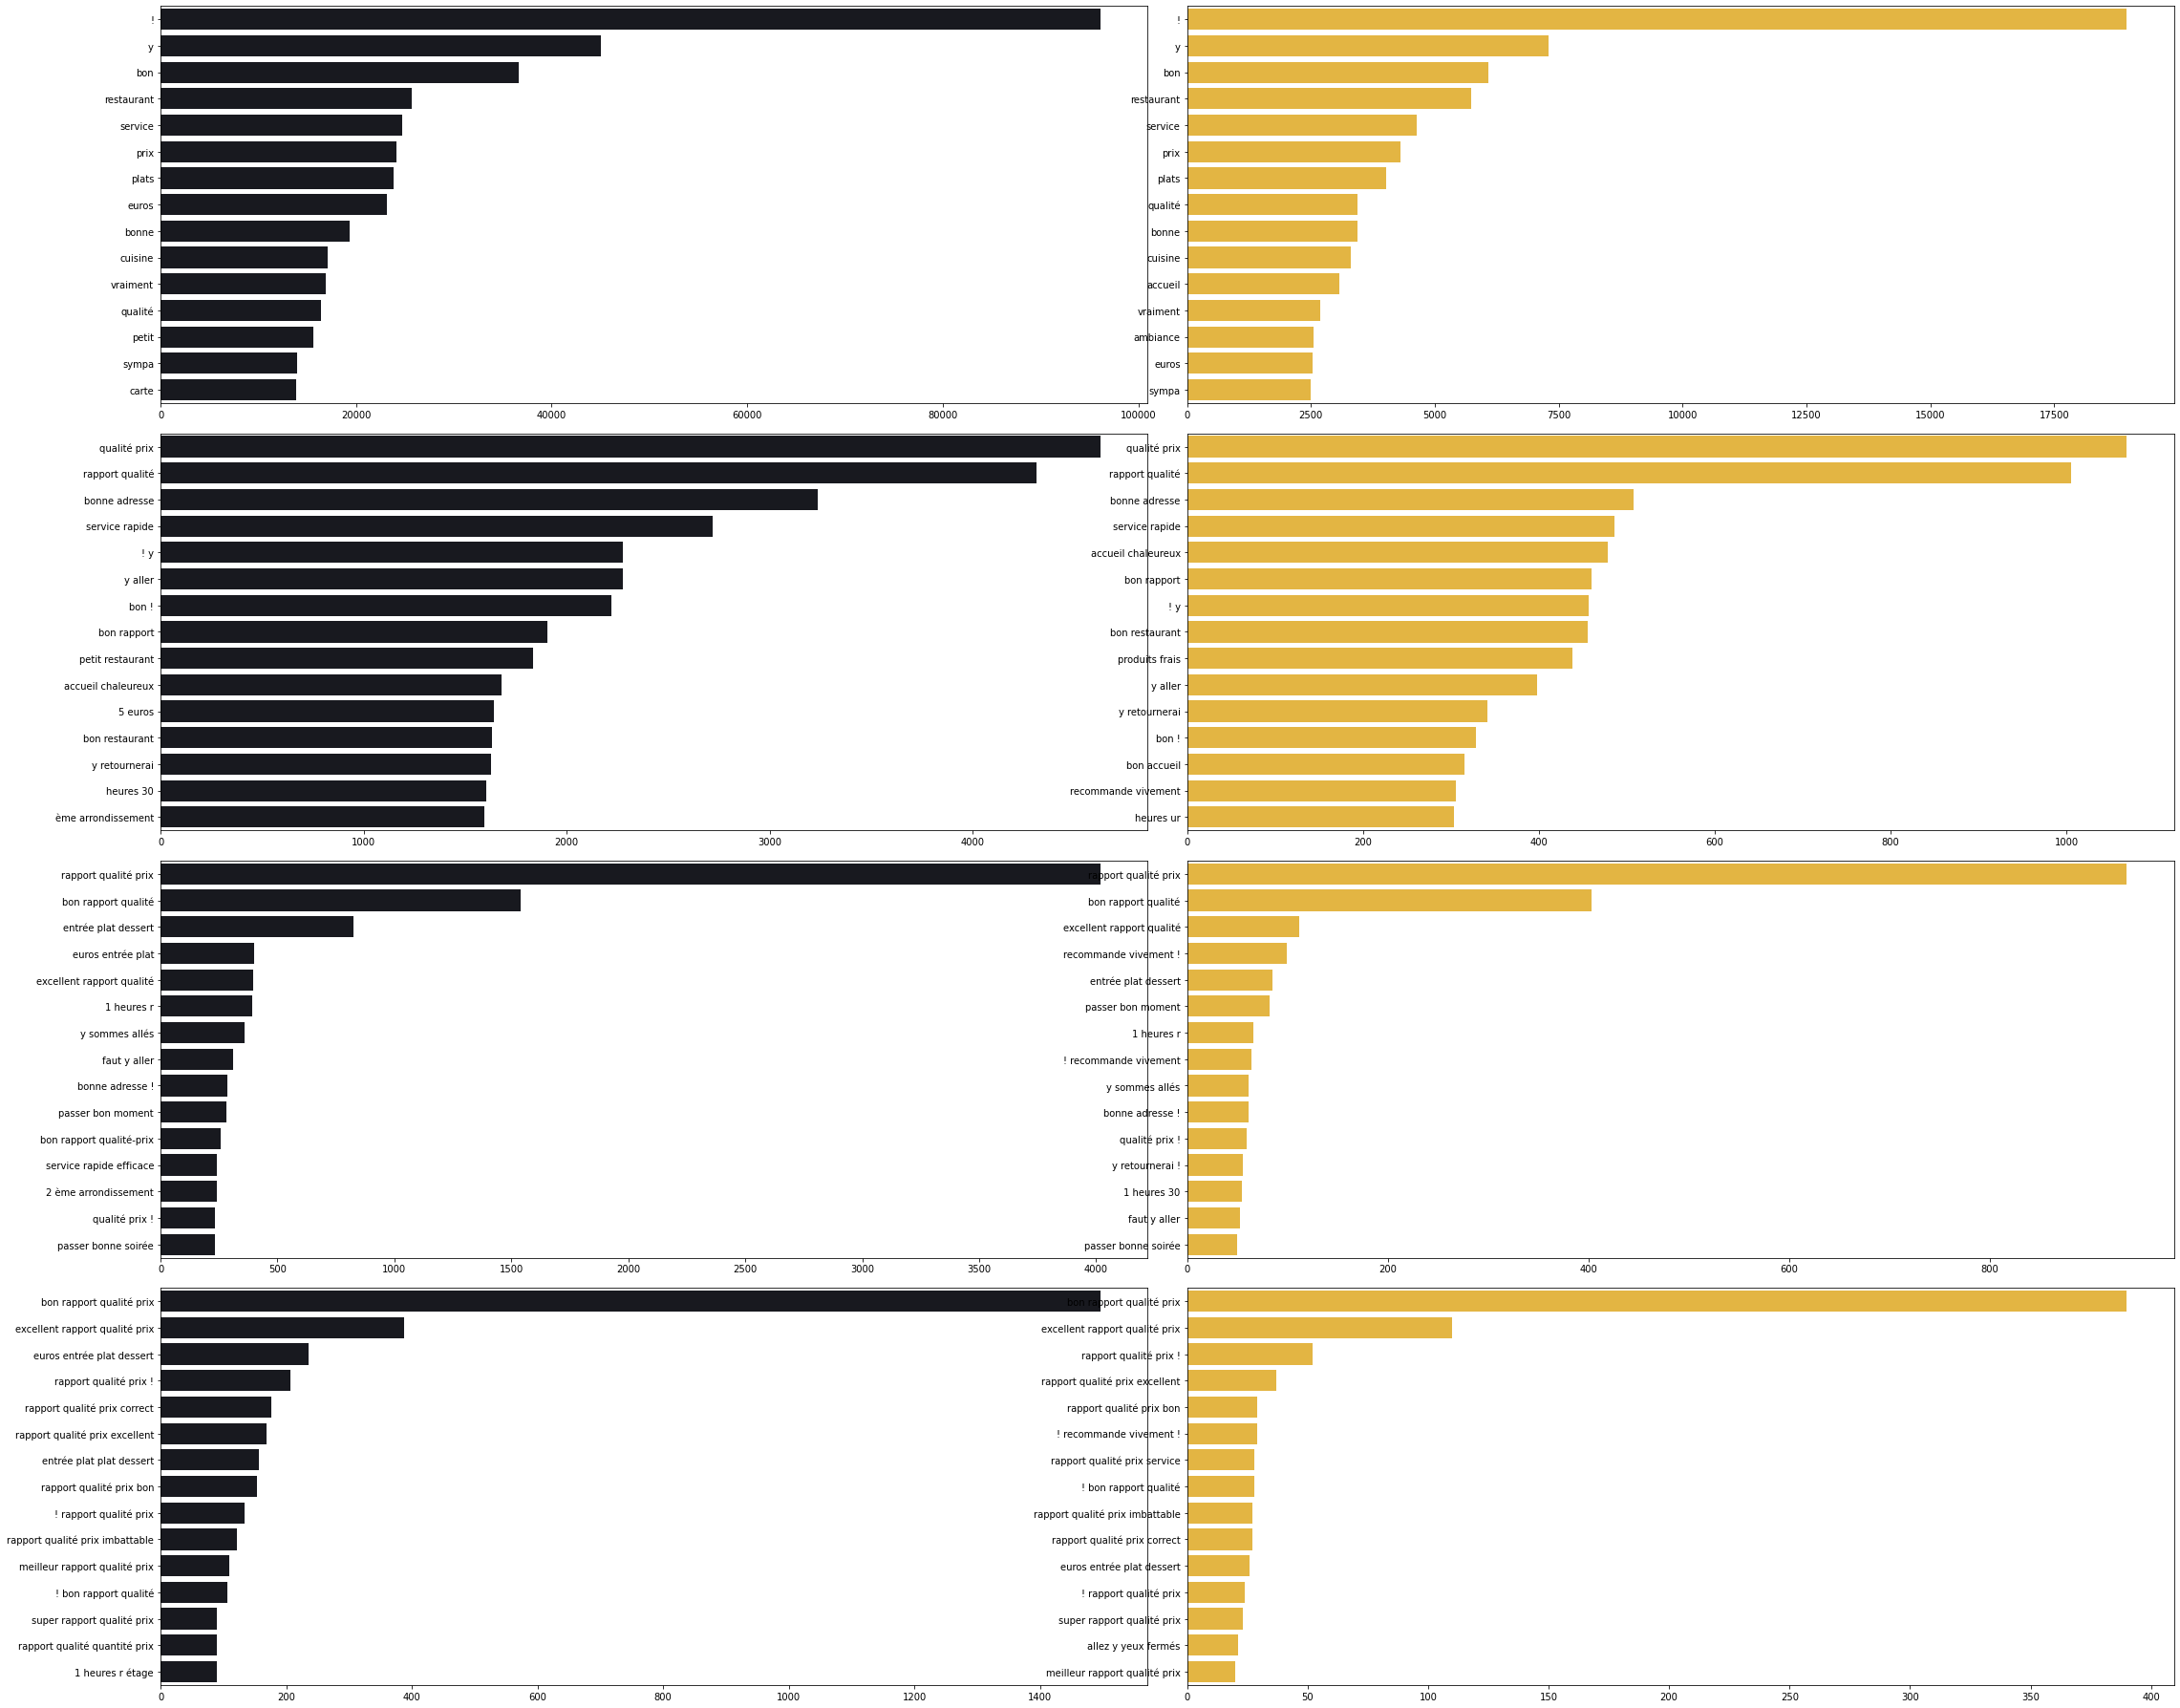

In [31]:
N = 15

fig, ax = plt.subplots(4, 2, figsize = (30, 25))
plt.tight_layout()
#unigram plots
sns.barplot(y = non_fake_df_unigram[0].values[:N], x = non_fake_df_unigram[1].values[:N], ax = ax[0, 0], color='#171820')
sns.barplot(y = fake_df_unigram[0].values[:N], x = fake_df_unigram[1].values[:N], ax = ax[0, 1], color = '#fdc029')
#bigram plots
sns.barplot(y = non_fake_df_bigram[0].values[:N], x = non_fake_df_bigram[1].values[:N], ax = ax[1, 0], color='#171820')
sns.barplot(y = fake_df_bigram[0].values[:N], x = fake_df_bigram[1].values[:N], ax = ax[1, 1], color = '#fdc029')
#trigram plots
sns.barplot(y = non_fake_df_trigram[0].values[:N], x = non_fake_df_trigram[1].values[:N], ax = ax[2, 0], color='#171820')
sns.barplot(y = fake_df_trigram[0].values[:N], x = fake_df_trigram[1].values[:N], ax = ax[2, 1], color = '#fdc029')
#fourgram plots
sns.barplot(y = non_fake_df_fourgram[0].values[:N], x = non_fake_df_fourgram[1].values[:N], ax = ax[3, 0], color='#171820')
sns.barplot(y = fake_df_fourgram[0].values[:N], x = fake_df_fourgram[1].values[:N], ax = ax[3, 1], color = '#fdc029')

## Tokenization and embedding with spacy


In [26]:
french_reviews['text_review_clean'].head()

0    bon retour ! je suis revenue dans ce resto apr...
1    a optimiser cuisine très traditionnelle dans u...
2    brasserie chic une brasserie authentiquement p...
3    tres bien petit diner entre amis les plats eta...
4    un bistrot bien sympathique nous avons mangé e...
Name: text_review_clean, dtype: object

In [27]:
#We compute the max length of a sentence

#we fit the tokenizer on train and test to have all the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(french_reviews['text_review_clean'])

french_reviews["review_encoded"] = tokenizer.texts_to_sequences(french_reviews["text_review_clean"] )

### we use padding to add up zeros to all our sentences so that they are all the same length
reviews_pad = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(french_reviews["review_encoded"], padding="post"))

In [28]:
reviews_pad.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948
0,33,1367,9,71,4352,27,25,86,109,13,685,2449,1,188,494,12,155,2,326,20,1131,5,55,68,19,166,156,95,68,51,3,1035,2,421,4,17,666,3,787,10058,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,12924,55,17,783,27,6,172,1,301,80,2,42,4,1502,8,44,30,377,1369,3,14,337,2865,10,131,19,6,327,1780,15,49,20,10,2466,1,1522,2,110,1006,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,301,771,13,301,5985,654,11,6,148,43,2,1641,19,1003,1105,1,6901,9,15,37,10,9430,7,5,29297,1,10551,2,326,15,38,4,10,62,131,19755,340,8,7476,42,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,289,35,59,453,94,162,8,44,3494,106,8,211,465,3,5,896,1,3765,3321,25,130,102,21,1048,79,380,11,13,301,3,118,9,332,2,101,18,38,1242,27,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,409,35,153,32,84,280,14,588,27,25,39,1,626,409,26,4,17,153,2,148,47,17,33,3,2,42,479,498,2,271,4,378,9,281,25,39,105,31,4353,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
word_index = tokenizer.word_index

#for each word in our dataset we will get the corresponding 96D Spacy vector, we will then build an embedding matrix with each of these vectors 

word_index = tokenizer.word_index
EMBEDDING_DIM = 96
missing_words = []
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add spacy word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = nlp(word).vector
    if embedding_vector is None:
      missing_words.append(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 81024/81024 [08:45<00:00, 154.31it/s]

Our embedded matrix is of dimension (81025, 96)


# Feature Engineering

In [36]:
superlatifs = ['bon', 'bonne', 'bons', 'bonnes', 'meilleur', 'meilleure', 'meilleures',
'mauvais', 'mauvaise', 'pire','petit', 'petite', 'moindre','plus', 'mieux', 'gros', 'impossible', 'totalement', 'loin', 'absence', 'très', 'tres', 'décu', 'decu', 'trop', 'jamais', 'toujours', 'aucun', 'déplorable', 'éviter', 'eviter', 'absolument', 'infect', 'infecte', 'fuir', 'fuire']

In [37]:
#adding a column with the text review length
french_reviews['text_length'] = french_reviews['text_review_clean'].apply(lambda x : len(x))

#We then compute the amount of ! ? . and %  within a review
french_reviews['punctuation_count'] = french_reviews['text_review'].apply(lambda x : len(''.join(ch for ch in x if ch =='!' or ch == '?' or ch == '.' or ch =='%')))

#We also compute the amount of uppercase words in a review
french_reviews['upper_word_count'] = french_reviews['text_review'].apply(lambda x : sum(map(str.isupper, x.split())) )

#Average word length in a tweet
french_reviews['average_word_length'] = french_reviews['text_review_clean'].apply(lambda x : np.mean([len(word) for word in x.split()]) )

#number of digits
french_reviews['digits'] = french_reviews['text_review_clean'].apply(lambda x: len(''.join(ch for ch in x if ch.isnumeric())) )

#Negation
french_reviews['negation'] = french_reviews['text_review_clean'].apply(lambda x :  len([word for word in x.split() if word in ['n', 'ne']]) )

#Count of Superlatives
french_reviews['sup_count'] = french_reviews['text_review_clean'].apply(lambda x :  len([word for word in x.split() if word in superlatifs]) )

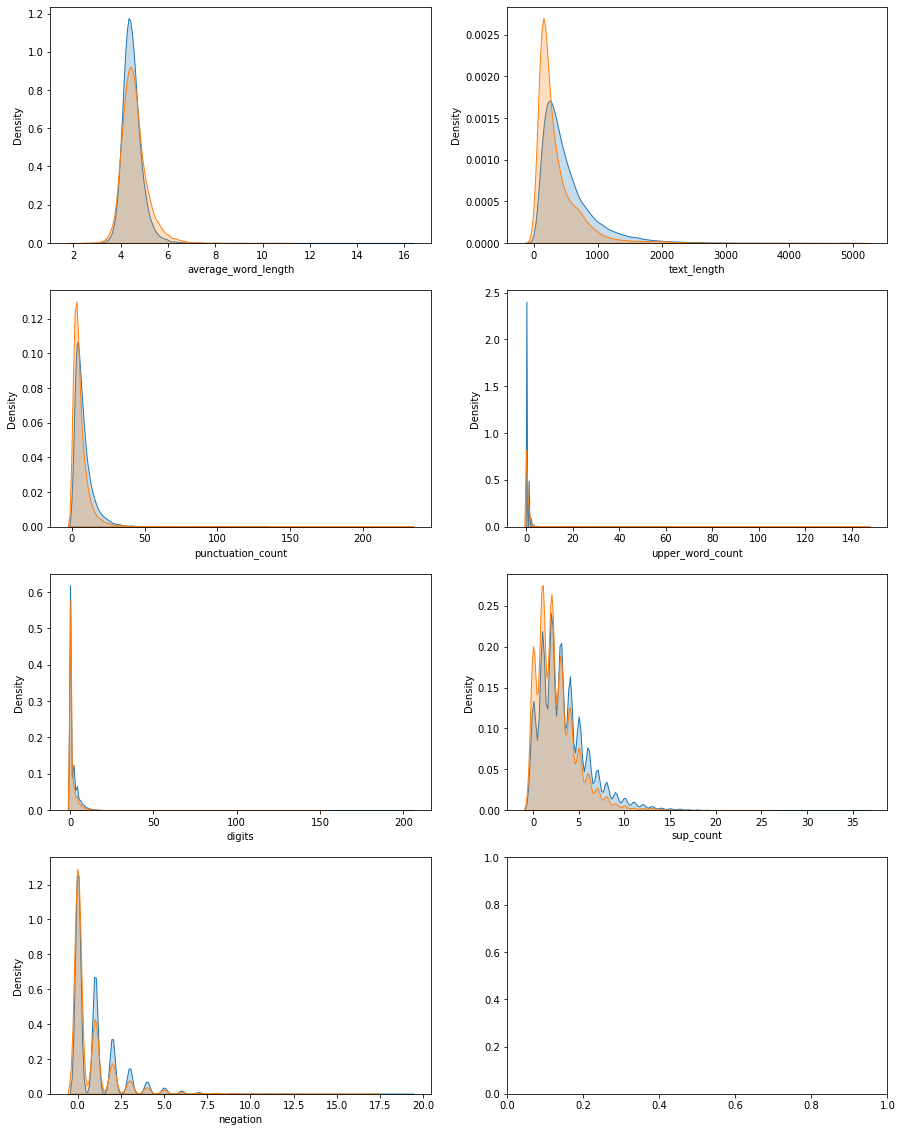

In [38]:
#define subplot to see graphs side by side
fig, ( (ax1,ax2), (ax3, ax4), (ax5,ax6), (ax7, ax8) ) = plt.subplots(4,2, figsize = (15, 20))

#average word length
a=sns.kdeplot(french_reviews['average_word_length'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax1)
a=sns.kdeplot(french_reviews['average_word_length'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax1)

#tweet len
t=sns.kdeplot(french_reviews['text_length'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax2)
t=sns.kdeplot(french_reviews['text_length'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax2)

#word count
e=sns.kdeplot(french_reviews['punctuation_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax3)
e=sns.kdeplot(french_reviews['punctuation_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax3)

#link count
u=sns.kdeplot(french_reviews['upper_word_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax4)
u=sns.kdeplot(french_reviews['upper_word_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax4)


#number of digits
d=sns.kdeplot(french_reviews['digits'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax5)
d=sns.kdeplot(french_reviews['digits'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax5)

#superlatives count
s=sns.kdeplot(french_reviews['sup_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax6)
s=sns.kdeplot(french_reviews['sup_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax6)

#negations
n=sns.kdeplot(french_reviews['negation'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax7)
n=sns.kdeplot(french_reviews['negation'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax7)

#plt.legend()
plt.show()

# Concatenate metadata with new features created

In [39]:
df_new_features = french_reviews.iloc[:, -7:]
df_new_features.head()

,text_length,punctuation_count,upper_word_count,average_word_length,digits,negation,sup_count
0,355,7,0,4.220588,1,0,7
1,251,6,1,4.704545,0,1,3
2,320,7,0,4.714286,0,2,2
3,245,5,1,4.326087,2,0,3
4,277,3,0,4.770833,0,0,3


In [40]:
df_meta_data = dataset.loc[dataset['language'] =='fr', [c for c in dataset.columns if c not in ['text_length','text_review_clean', 'review_encoded','date', 'username', 'text_review', 'user_location', 'restaurant_name', 'url', 'user_total_image_posted', 'language',  'is_fake_review', 'url_not_recommended']]]
df_meta_data.head()

,photos_for_review,rating,user_friends_count,user_reviews_count,restaurant_average_rating,restaurant_reviews_count,restaurant_expensiveness
0,0,5.0,0.0,4.0,3.0,19.0,-1
1,0,3.0,0.0,22.0,3.0,19.0,-1
2,0,3.0,11.0,155.0,3.0,19.0,-1
3,0,4.0,0.0,10.0,3.0,19.0,-1
4,0,4.0,0.0,2.0,3.0,19.0,-1


In [41]:
print('meta_data shape : ', df_meta_data.shape)
print('engineered feature shape : ', df_new_features.shape)
df_meta = pd.concat([df_meta_data, df_new_features ], axis = 1)
print('concatenate df : ',df_meta.shape)

df_meta.head()

meta_data shape :  (90597, 7)
engineered feature shape :  (90597, 7)
concatenate df :  (90597, 14)


,photos_for_review,rating,user_friends_count,user_reviews_count,restaurant_average_rating,restaurant_reviews_count,restaurant_expensiveness,text_length,punctuation_count,upper_word_count,average_word_length,digits,negation,sup_count
0,0,5.0,0.0,4.0,3.0,19.0,-1,355,7,0,4.220588,1,0,7
1,0,3.0,0.0,22.0,3.0,19.0,-1,251,6,1,4.704545,0,1,3
2,0,3.0,11.0,155.0,3.0,19.0,-1,320,7,0,4.714286,0,2,2
3,0,4.0,0.0,10.0,3.0,19.0,-1,245,5,1,4.326087,2,0,3
4,0,4.0,0.0,2.0,3.0,19.0,-1,277,3,0,4.770833,0,0,3


# Simple Neural Network

### Preprocessing and train test split

In [25]:
y = french_reviews['is_fake_review']
#split reviews_pad
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(reviews_pad, y, test_size=0.20, random_state=42, stratify = y)

#We put everything in a tensorflow dataset
train = tf.data.Dataset.from_tensor_slices((X_train_t, y_train_t))
test = tf.data.Dataset.from_tensor_slices(( X_test_t, y_test_t))

train = train.shuffle(len(train)).batch(512)
test = test.shuffle(len(test)).batch(512)

### Model Architecture

In [26]:
#We use the following lines to get the shape of a text element in our tensorflow dataset
for text, label in train.take(1):
  text_input_shape = text.shape[1]
  print(text)


tf.Tensor(
[[   6   77   58 ...    0    0    0]
 [  23  967   22 ...    0    0    0]
 [  93  515    3 ...    0    0    0]
 ...
 [9480 2587 7539 ...    0    0    0]
 [  93 6252   11 ...    0    0    0]
 [ 515    9   71 ...    0    0    0]], shape=(512, 949), dtype=int32)


In [27]:
#we get the vocabsize
vocab_size = len(tokenizer.word_index)
vocab_size

81024

In [28]:
model = tf.keras.Sequential([
                             
                  #Embedding Layer          
                  tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_shape=[text_input_shape,],
                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                  trainable=False),

                  tf.keras.layers.Dropout(0.6), 
                  #Bidirectional
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(80, return_sequences=True)),
                  
                  tf.keras.layers.Dropout(0.6),  

                  tf.keras.layers.Flatten(),   
                  
                  #Dense
                  tf.keras.layers.Dense(128, activation='relu'),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),


                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
 #                 tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer= tf.keras.regularizers.l1(10))
                                              
])

In [29]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes= 1, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


# We use the Adam optimizer 
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01,
                                    epsilon=1e-08,
                                    decay=0.01,
                                    clipnorm=1.0)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

class_weight = {
    0:1,
    1:4.3,
}

In [30]:
#callback to save the best model
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)



# We train the model
history = model.fit(train, 
                    epochs=15, 
                    validation_data=test,
                    class_weight=class_weight,
                    #callbacks=[model_checkpoint_callback]
                    )

Epoch 1/15
142/142 [==============================] - 60s 349ms/step - loss: 1.3591 - accuracy: 0.6274 - f1_score: 0.3629 - precision: 0.2753 - recall: 0.5412 - val_loss: 0.6269 - val_accuracy: 0.7425 - val_f1_score: 0.3956 - val_precision: 0.3599 - val_recall: 0.4392
Epoch 2/15
142/142 [==============================] - 50s 352ms/step - loss: 1.0561 - accuracy: 0.6925 - f1_score: 0.4008 - precision: 0.3211 - recall: 0.5336 - val_loss: 0.5921 - val_accuracy: 0.7416 - val_f1_score: 0.3997 - val_precision: 0.3606 - val_recall: 0.4484
Epoch 3/15
142/142 [==============================] - 51s 360ms/step - loss: 1.0389 - accuracy: 0.6801 - f1_score: 0.4071 - precision: 0.3149 - recall: 0.5773 - val_loss: 0.5992 - val_accuracy: 0.6838 - val_f1_score: 0.4247 - val_precision: 0.3263 - val_recall: 0.6083
Epoch 4/15
142/142 [==============================] - 51s 358ms/step - loss: 1.0224 - accuracy: 0.6516 - f1_score: 0.4137 - precision: 0.3040 - recall: 0.6477 - val_loss: 0.5588 - val_accuracy:

# Mixed Data Neural Network (LSTM)

## Preprocessing and Train Test Split


In [45]:
y = french_reviews['is_fake_review']


X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(df_meta, y, test_size=0.20, random_state=42, stratify = y)

#we use a scaler from sklearn
scaler = StandardScaler()
X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

In [46]:
#split reviews_pad
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(reviews_pad, y, test_size=0.20, random_state=42, stratify = y)

In [48]:
#We put everything in a tensorflow dataset
train = tf.data.Dataset.from_tensor_slices(({'text': X_train_t, 'metadata': X_train_m }, y_train_t))
test = tf.data.Dataset.from_tensor_slices(({'text': X_test_t, 'metadata': X_test_m }, y_test_t))

train = train.shuffle(len(train)).batch(512)
test = test.shuffle(len(test)).batch(512)

## Model Architecture

In [49]:
for data, label in train.take(1):
  text_input_shape = data['text'].shape[1]
  metadata_input_shape = data['metadata'].shape[1]


In [50]:
vocab_size = len(tokenizer.word_index)
vocab_size

81024

In [51]:
input_text = keras.Input(shape=(text_input_shape,), name="text")  
input_metadata = keras.Input(shape=(metadata_input_shape,), name="metadata")  

# Input Word Embedding, we initialize with the glove embedding matrix and make the layer non trainable
text_features = tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_shape=[text_input_shape,],
                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                  trainable=False)(input_text)           

text_features = layers.Bidirectional(tf.keras.layers.LSTM(55, return_sequences=True))(text_features)
text_features = layers.Dropout(0.6)(text_features)

text_features = layers.Flatten()(text_features)

#We concatenate both text and metadata here
x_input = layers.concatenate([text_features, input_metadata])

#x_features = tf.keras.layers.Dense(64, activation='relu')(x_input)
#x_features = layers.Dropout(0.7)(x_input)
#x_features = tf.keras.layers.Dense(32, activation='relu')(x_features)
#x_features = tf.keras.layers.Dense(16, activation='relu')(x_features)
#x_features = tf.keras.layers.Dense(8, activation='relu')(x_features)

#we put a regularization to limit the overfitting
#x_pred= tf.keras.layers.Dense(1, activation="sigmoid")(x_input)
x_pred= tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l1(0.00001))(x_input)

model = keras.Model(
    inputs=[input_text, input_metadata],
    outputs= x_pred
)


In [52]:
73211/17386

4.210916829633038

In [53]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes= 1, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


# We use the Adam optimizer 
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    epsilon=1e-08,
                                    decay=0.01,
                                    clipnorm=1.0)


#Compile the model
model.compile(optimizer=optimizer,
              #loss= macro_soft_f1,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

class_weight = {
    0:1,
    1:4.21,
}


#callback to save the best model
checkpoint_filepath = '/content/checkpoint-mixed'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)


history = model.fit(train, 
                    epochs=20, 
                    validation_data=test,
                    class_weight=class_weight,
                    #callbacks=[model_checkpoint_callback]
                    )

Epoch 1/20
142/142 [==============================] - 47s 263ms/step - loss: 1.0670 - accuracy: 0.6168 - f1_score: 0.3878 - precision: 0.2811 - recall: 0.6272 - val_loss: 0.5696 - val_accuracy: 0.7266 - val_f1_score: 0.4505 - val_precision: 0.3667 - val_recall: 0.5841
Epoch 2/20
142/142 [==============================] - 37s 258ms/step - loss: 0.9456 - accuracy: 0.6964 - f1_score: 0.4703 - precision: 0.3540 - recall: 0.7010 - val_loss: 0.5538 - val_accuracy: 0.7259 - val_f1_score: 0.4566 - val_precision: 0.3685 - val_recall: 0.5999
Epoch 3/20
142/142 [==============================] - 37s 259ms/step - loss: 0.9120 - accuracy: 0.7079 - f1_score: 0.4928 - precision: 0.3713 - recall: 0.7330 - val_loss: 0.5800 - val_accuracy: 0.7010 - val_f1_score: 0.4638 - val_precision: 0.3536 - val_recall: 0.6739
Epoch 4/20
142/142 [==============================] - 37s 261ms/step - loss: 0.8901 - accuracy: 0.7083 - f1_score: 0.5014 - precision: 0.3750 - recall: 0.7568 - val_loss: 0.5652 - val_accuracy:

KeyboardInterrupt: ignored

## Load Best model and predict

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

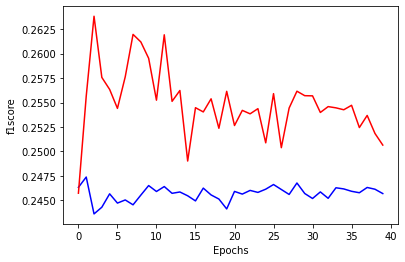

In [ ]:
# Visualisation de l'entrainement sur l'accuracy 
plt.plot(history.history["f1_score"], color="b")
plt.plot(history.history["val_f1_score"], color="r")
plt.ylabel("f1score")
plt.xlabel("Epochs")
plt.show()

# Mixed Data Model (Topic Modelling)

## Vectorize

In [42]:
# apply vectorizer to the review column
vectorizer = TfidfVectorizer(smooth_idf=True, min_df=200)
X_vect = vectorizer.fit_transform(french_reviews['text_review_clean'])
len(vectorizer.vocabulary_)

2655

## Topic Extraction

In [43]:
# set it to 200 different topics 
svd = TruncatedSVD(n_components= 200)
# fit to our matrix --> last two columns are those with the previous cluster_values
lsa = svd.fit_transform(X_vect)

print(svd.explained_variance_ratio_.sum())

0.37591915003949405


## Train Test Split and making tensors datasets

In [44]:
#We split, and we make sure to have the same random_state as the one we used to split the text, this way the data is split the same way.
y = french_reviews['is_fake_review']

X_train_m, X_test_m, y_train, y_test = train_test_split(df_meta, y, 
                                                    test_size = 0.2,
                                                    stratify = y , 
                                                    random_state = 42)
#we use a scaler from sklearn
scaler = StandardScaler()
X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

In [45]:
X_train_t, X_test_t, y_train, y_test = train_test_split(lsa,y, 
                                                    test_size = 0.2,
                                                    stratify = y , ## Statify splitting when you're training a classification model !
                                                    random_state = 42)

In [46]:
X_train = np.concatenate([X_train_t, X_train_m], axis=1)
X_test = np.concatenate([X_test_t, X_test_m], axis=1)
print(X_train.shape)
print(X_test.shape)

(72477, 214)
(18120, 214)


In [47]:
### Train Test Split

#We use the concatenation of the lsa and the metadata
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test,  y_test))

train = train.shuffle(len(train)).batch(2000)
test = test.shuffle(len(test)).batch(2000)

## Model Architecture

In [48]:
for review, label in train.take(1):
  input_shape = review.shape[1]
  print(review)

tf.Tensor(
[[ 0.1402789   0.15873856 -0.0041603  ... -0.50727797 -0.66523566
  -0.07926765]
 [ 0.30993525 -0.01840194  0.1921617  ... -0.50727797  0.05183333
  -0.43934796]
 [ 0.30757848  0.24871975  0.0490022  ... -0.50727797 -0.66523566
   0.28081266]
 ...
 [ 0.32027113  0.06658766  0.01486768 ... -0.21130797 -0.66523566
  -0.43934796]
 [ 0.37413191 -0.00669766 -0.11238583 ...  0.08466203 -0.66523566
   0.64089297]
 [ 0.48438944 -0.06263248  0.01437329 ... -0.50727797  0.76890232
  -0.07926765]], shape=(2000, 214), dtype=float64)


In [49]:
#We define a loss function based on the f1 score
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [50]:
p = 0.3
model = tf.keras.Sequential([
                             
                  tf.keras.layers.Dense(512, activation='relu', input_shape=[input_shape], kernel_regularizer=keras.regularizers.l2(l=0.1)),
                  tf.keras.layers.Dense(256, activation='relu',),
                  tf.keras.layers.Dropout(0.5),
                  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=p)),
                  tf.keras.layers.Dense(256, activation='relu',),
                  tf.keras.layers.Dropout(0.5),
                  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=p)),
                  tf.keras.layers.Dense(256, activation='relu',),
                  tf.keras.layers.Dropout(0.5),
                  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=p)),
                  tf.keras.layers.Dense(64, activation='relu',),
                    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=p)),
                  tf.keras.layers.Dense(64, activation='relu',),
                  tf.keras.layers.Dropout(0.3),
                  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l=p)),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(l=p)),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
                                              
])



METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes= 1, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]



# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.96,
    staircase=True)

# Utilisation d'un compileur simple avec un optimiseur Adam pour le calcul de nos gradients 
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

model.compile(optimizer=optimizer,
              loss= macro_soft_f1,
#              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = METRICS)




class_weight = {
    0:1,
    1:2.5
}


#Saves the best model at the end of each epoch
checkpoint_filepath = '/content/checkpoint-mixed_topic_modelling'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)




In [51]:
 #Entrainement du modèle 
history = model.fit(train, 
                    epochs=200, 
                    validation_data=test,
                    class_weight = class_weight,
                    callbacks=[model_checkpoint_callback]
                  
)

Epoch 1/200
37/37 [==============================] - 4s 26ms/step - loss: 289.4095 - accuracy: 0.2045 - f1_score: 0.3186 - precision: 0.1903 - recall: 0.9778 - val_loss: 268.4762 - val_accuracy: 0.1919 - val_f1_score: 0.3220 - val_precision: 0.1919 - val_recall: 1.0000
INFO:tensorflow:Assets written to: /content/checkpoint-mixed_topic_modelling/assets
Epoch 2/200
37/37 [==============================] - 1s 15ms/step - loss: 262.2047 - accuracy: 0.1924 - f1_score: 0.3227 - precision: 0.1924 - recall: 1.0000 - val_loss: 243.1461 - val_accuracy: 0.1919 - val_f1_score: 0.3220 - val_precision: 0.1919 - val_recall: 1.0000
Epoch 3/200
37/37 [==============================] - 1s 15ms/step - loss: 237.4634 - accuracy: 0.1911 - f1_score: 0.3209 - precision: 0.1911 - recall: 1.0000 - val_loss: 220.1526 - val_accuracy: 0.1919 - val_f1_score: 0.3220 - val_precision: 0.1919 - val_recall: 1.0000
Epoch 4/200
37/37 [==============================] - 1s 16ms/step - loss: 215.0107 - accuracy: 0.1920 - f1

#Load Best model

In [52]:
model = tf.keras.models.load_model('/content/checkpoint-mixed_topic_modelling', custom_objects={'macro_soft_f1':                   
macro_soft_f1})

# Prediction on new data

In [55]:
df_meta.head()

,photos_for_review,rating,user_friends_count,user_reviews_count,restaurant_average_rating,restaurant_reviews_count,restaurant_expensiveness,text_length,punctuation_count,upper_word_count,average_word_length,digits,negation,sup_count
0,0,5.0,0.0,4.0,3.0,19.0,-1,355,7,0,4.220588,1,0,7
1,0,3.0,0.0,22.0,3.0,19.0,-1,251,6,1,4.704545,0,1,3
2,0,3.0,11.0,155.0,3.0,19.0,-1,320,7,0,4.714286,0,2,2
3,0,4.0,0.0,10.0,3.0,19.0,-1,245,5,1,4.326087,2,0,3
4,0,4.0,0.0,2.0,3.0,19.0,-1,277,3,0,4.770833,0,0,3


In [108]:
review = "Comme Alexis je pense qu'il n'y a pas d'équivalent sur ce genre de cuisine,il faut aimer les légumes toutefois, le goût est démultiplié. C'est ici que j'ai mangé les meilleures amuses bouches et mignardises,sur le tout un sans faute sauf peu être le mille-feuille en dessert qui manque un peu de crème mais c'est vraiment pour chipoter. Le déjeuner est passer à 140 euros,j'y est déjeuner avec un proche pour un anniversaire et elle m'as dis que c'était le plus beau cadeau qu'on lui a fait."

In [109]:
photos_for_review = 0
rating = 5
user_friends_count = 108
user_reviews_count = 183
restaurant_average_rating = 4
restaurant_reviews_count = 212
restaurant_expensiveness = 4

## Feature Engineering

In [120]:
#adding a column with the text review length
text_length = len(review)
#We then compute the amount of exclamation points within a review,
punctuation_count = len(''.join(ch for ch in review if ch =='!' or ch == '?' or ch == '.' or ch =='%'))
#We also compute the amount of uppercase words in a review, 
upper_word_count = sum(map(str.isupper, review.split() )) 
#Average word length in a tweet
average_word_length = np.mean([len(word) for word in review.split()])
#number of digits
digits = len(''.join(ch for ch in review if ch.isnumeric())) 
#Negation
negation= len([word for word in review.split() if word in ['n', 'ne']])
#Count of Superlatives
sup_count = len([word for word in review.split() if word in superlatifs])

## Text Cleaning

In [111]:
review = re.sub(r"[\n]", ' ', review)
review = review.lower()
#expand contractions
review = expand_text(review)
#remove special character and multiple occurences of a letter
review = cleaner(review)
#remove multiple white spaces
review = re.sub(r" +"," ", review)
#keep only alphanum or ! or ? or -
review = "".join(ch for ch in review if ch.isalnum() or ch == '!' or ch =='?' or ch ==' ' or ch == '-' or ch =='%')
review = fix_fancy_words(review)
review

'comme alexis je pense que il ne y a pas de équivalent sur ce genre de cuisine il faut aimer les légumes toutefois le goût est démultiplié ceci est ici que je ai mangé les meilleures amuses bouches et mignardises sur le tout un sans faute sauf peu être le mille-feuille en dessert qui manque un peu de crème mais ceci est vraiment pour chipoter le déjeuner est passer à 140 euros je y est déjeuner avec un proche pour un anniversaire et elle me as dis que ceci était le plus beau cadeau que on lui a fait '

In [112]:
#creating topic matrix
vect_review = vectorizer.transform([review])
topics = svd.transform(vect_review)

In [131]:
#creating metadata vector
meta_vector = np.array([[photos_for_review, rating, user_friends_count, user_reviews_count, restaurant_average_rating, restaurant_reviews_count, restaurant_expensiveness,
              text_length, punctuation_count, upper_word_count, average_word_length, digits, negation, sup_count]])
#normalize data
meta_vector = scaler.transform(meta_vector)


In [114]:
#concatenate both to create input vector
input_vector = np.concatenate([topics, meta_vector], axis = 1)

In [125]:
proba_fake = model.predict(input_vector)[0][0]
np.round(value)

0.0

## Export tools with joblib

In [128]:
#Scaler
joblib_file = "data_scaler.pkl"
joblib.dump(scaler, joblib_file)

#Vectorizer
joblib_file = "text_vectorizer.pkl"
joblib.dump(vectorizer, joblib_file)

#Topic Extractor
joblib_file = "topic_extractor.pkl"
joblib.dump(svd, joblib_file)

['topic_extractor.pkl']

In [130]:
#Scaler
joblib_file = "expand_text.pkl"
joblib.dump(expand_text, joblib_file)

#Vectorizer
joblib_file = "cleaner.pkl"
joblib.dump(cleaner, joblib_file)

#Topic Extractor
joblib_file = "fix_fancy_words.pkl"
joblib.dump(fix_fancy_words, joblib_file)

['fix_fancy_words.pkl']